In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/ColabNotebooks/filtered_en-fr.csv', nrows=200000)
len(df)

200000

In [ ]:
pip install transformers[torch]

In [ ]:
pip install accelerate -U

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, MT5ForConditionalGeneration

model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
print("Original DataFrame:")
print(df.head())
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Shuffled DataFrame:")
print(df_shuffled.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used

Original DataFrame:
                                                  en  \
0  Give your listeners a signal that you are wrap...   
1  • Federal institutional governance ($3 billion...   
2                 The "placebo" or "healing" effect.   
3                                 VACUUM CLEANERS 10   
4       • 630-A-1992 — Cancellation - Alkan Air Ltd.   

                                                  fr  
0  Exemple : « Pouvons-nous nous permettre de le ...  
1  • Gouvernance des institutions fédérales (3 MM...  
2            L'effet " placebo " ou " de guérison ".  
3                - Remorques servant d'habitation 10  
4         • 630-A-1992 — Annulation - Alkan Air Ltd.  
Shuffled DataFrame:
                                                  en  \
0          Of the estimated 21.52 investigations per   
1  The first is "Fifty-Five Plus", which is a Man...   
2               Women in senior government positions   
3  Directorate of Social and Economic Analyis, De...   
4            

In [ ]:
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

num_rows = len(df_shuffled)
num_train = int(num_rows * train_ratio)
num_validation = int(num_rows * validation_ratio)
num_test = num_rows - num_train - num_validation

train_df = df_shuffled.iloc[:num_train]
validation_df = df_shuffled.iloc[num_train:num_train + num_validation]
test_df = df_shuffled.iloc[num_train + num_validation:]

train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Training dataframe shape:", train_df.shape)
print("Validation dataframe shape:", validation_df.shape)
print("Test dataframe shape:", test_df.shape)

Training dataframe shape: (160000, 2)
Validation dataframe shape: (20000, 2)
Test dataframe shape: (20000, 2)


In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
prefix = 'translate English to French: '

In [ ]:
pip install datasets

In [ ]:
def pair_columns(dataframe):
    text_pairs = []
    for i in range(0, dataframe.shape[0]):
        text_pairs.append((dataframe['en'][i], dataframe['fr'][i]))
    return text_pairs

In [ ]:
def preprocess_function(text_pairs):
    en_sentence, fr_sentence = zip(*text_pairs)
    inputs = [prefix + str(text) for text in en_sentence]
    targets = fr_sentence
    model_inputs = tokenizer(inputs, text_target=targets, max_length=64, truncation=True)
    return model_inputs

In [ ]:
tokenized_train = preprocess_function(pair_columns(train_df))
tokenized_val = preprocess_function(pair_columns(validation_df))

In [ ]:
print(tokenized_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(tokenized_val)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MT5ForConditionalGeneration, Trainer, TrainingArguments


class TranslationDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)


train_dataset = TranslationDataset(tokenized_train)
val_dataset = TranslationDataset(tokenized_val)
model.train()

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    logging_steps=2000,
    evaluation_strategy="steps",
    eval_steps=2000,
    save_steps=2000,
    warmup_steps=500,
    save_total_limit=2,
    learning_rate=2e-5,
)


model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


trainer.train()
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Step,Training Loss,Validation Loss
2000,8.754300,2.619978
4000,3.529800,2.386781
6000,3.218900,2.288757
8000,3.050800,2.228711
10000,2.941400,2.179747
12000,2.863100,2.142466
14000,2.797400,2.115355
16000,2.754200,2.097736
18000,2.720500,2.083050
20000,2.697200,2.068107


{'eval_loss': 2.039548873901367,
 'eval_runtime': 47.6429,
 'eval_samples_per_second': 419.79,
 'eval_steps_per_second': 13.118,
 'epoch': 6.0}

In [ ]:
trainer.save_model("./mt5-finetuned-200k")
model_path = "./mt5-finetuned-200k"
model = MT5ForConditionalGeneration.from_pretrained(model_path)

[{'loss': 8.7543, 'grad_norm': 3.660024881362915, 'learning_rate': 1.898305084745763e-05, 'epoch': 0.4, 'step': 2000}, {'eval_loss': 2.619978427886963, 'eval_runtime': 47.4599, 'eval_samples_per_second': 421.408, 'eval_steps_per_second': 13.169, 'epoch': 0.4, 'step': 2000}, {'loss': 3.5298, 'grad_norm': 2.7391064167022705, 'learning_rate': 1.76271186440678e-05, 'epoch': 0.8, 'step': 4000}, {'eval_loss': 2.3867805004119873, 'eval_runtime': 47.4344, 'eval_samples_per_second': 421.635, 'eval_steps_per_second': 13.176, 'epoch': 0.8, 'step': 4000}, {'loss': 3.2189, 'grad_norm': 2.6326069831848145, 'learning_rate': 1.6271186440677967e-05, 'epoch': 1.2, 'step': 6000}, {'eval_loss': 2.288756847381592, 'eval_runtime': 47.5228, 'eval_samples_per_second': 420.851, 'eval_steps_per_second': 13.152, 'epoch': 1.2, 'step': 6000}, {'loss': 3.0508, 'grad_norm': 2.691988229751587, 'learning_rate': 1.4915254237288137e-05, 'epoch': 1.6, 'step': 8000}, {'eval_loss': 2.2287113666534424, 'eval_runtime': 47.41

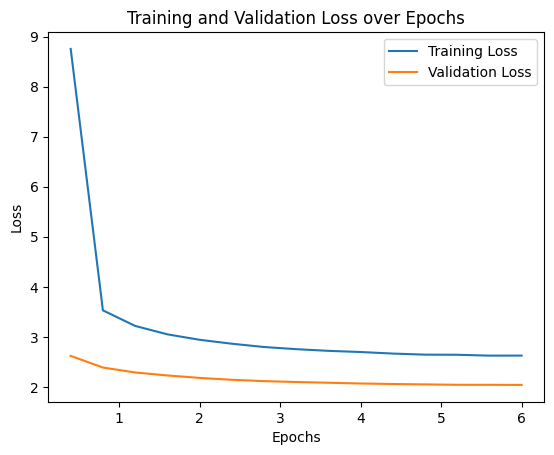

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_logs = trainer.state.log_history
print(train_logs)

train_loss = []
val_loss = []
train_epochs = []

num_steps = 0

for log in train_logs:
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        val_loss.append(log['eval_loss'])
        current_epoch = len(val_loss) * training_args.eval_steps / len(train_dataset) * training_args.per_device_train_batch_size
        train_epochs.append(current_epoch)
        num_steps += training_args.eval_steps

min_len = min(len(train_loss), len(val_loss))
train_loss = train_loss[:min_len]
val_loss = val_loss[:min_len]

plt.plot(train_epochs[:min_len], train_loss, label='Training Loss')
plt.plot(train_epochs[:min_len], val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [ ]:

def translate_text(text, model, tokenizer):
    inputs = tokenizer.encode("translate English to French: " + text, return_tensors="pt")
    outputs = model.generate(inputs, max_length=64, num_beams=4, early_stopping=True)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return translated_text

In [ ]:
pip install torch nltk sacrebleu matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
train_df.to_csv('train.csv', index=False)

In [ ]:
import shutil
from google.colab import drive

drive.mount('/content/drive')

source_directory = "/content/mt5-finetuned-200k"

destination_directory = "/content/drive/My Drive/mT5_albert_200k"

shutil.copytree(source_directory, destination_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/mT5_albert_200k'

In [ ]:
source_directory = "/content/train.csv"
destination_directory = "/content/drive/My Drive/mT5_albert_200k"
shutil.copy(source_directory, destination_directory)

'/content/drive/My Drive/mT5_albert_200k/train.csv'